# Pytorch入门实战（2）-使用BP神经网络实现MNIST手写数字识别

# 涉及知识点

[Pytorch nn.Module的基本使用](https://blog.csdn.net/zhaohongfei_358/article/details/122797244)

[Pytorch nn.Linear的基本用法](https://blog.csdn.net/zhaohongfei_358/article/details/122797190)

[PytorchVision Transforms的基本使用](https://blog.csdn.net/zhaohongfei_358/article/details/122799782)

[Pytorch中DataLoader的基本用法](https://blog.csdn.net/zhaohongfei_358/article/details/122742656)

[Pytorch详解NLLLoss和CrossEntropyLoss](https://blog.csdn.net/qq_22210253/article/details/85229988)

[如何确定神经网络的层数和隐藏层神经元数量](https://zhuanlan.zhihu.com/p/100419971)

# 本文内容

本文将会使用BP神经网络（就是最普通的神经网络）实现一个MNIST手写数据集的实现。话不多说，直接开始。

本文所使用到的环境如下:

```
python==3.8.5
torch==1.10.2
torchvision==0.11.3
matplotlib==3.2.2
```

首先先导入需要的包:

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

定义transform对象，其定义了数据集中的图片应该做怎样的处理：

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

加载和下载训练数据集，这里使用pytorch提供的API进行下载。如果你下载不下来，可以使用[百度网盘链接](https://pan.baidu.com/s/1NmxIlPhaeKSz_kFwCOn6rA?pwd=6hfa)进行下载，然后解压即可。

In [6]:
train_set = datasets.MNIST('train_set', # 下载到该文件夹下
                          download=not os.path.exists('train_set'), # 是否下载，如果下载过，则不重复下载
                          train=True, # 是否为训练集
                          transform=transform # 要对图片做的transform
                         )
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: train_set
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

等待一段时间下载成功后，可以看到训练集中一共有6w个数据，接下来下载测试数据集：

In [7]:
test_set = datasets.MNIST('test_set',
                        download=not os.path.exists('test_set'),
                        train=False,
                        transform=transform
                       )
test_set

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_set\MNIST\raw\train-images-idx3-ubyte.gz to test_set\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_set\MNIST\raw\train-labels-idx1-ubyte.gz to test_set\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_set\MNIST\raw\t10k-images-idx3-ubyte.gz to test_set\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_set\MNIST\raw\t10k-labels-idx1-ubyte.gz to test_set\MNIST\raw



Dataset MNIST
    Number of datapoints: 10000
    Root location: test_set
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

测试数据集包含1w条数据

接下来构建训练数据集和测试数据集的DataLoader对象：

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


在上面，我们将其分成64个一组的图片，每个图片只有一个通道（灰度图），大小为28x28。抽一张绘制一下：

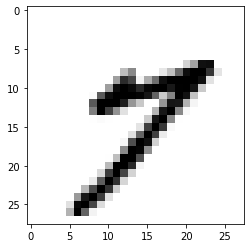

In [9]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

到这里，前期准备工作就结束了。

---

开始定义神经网络

In [10]:
class NerualNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        """
        定义第一个线性层，
        输入为图片（28x28），
        输出为第一个隐层的输入，大小为128。
        """
        self.linear1 = nn.Linear(28 * 28, 128)
        # 在第一个隐层使用ReLU激活函数
        self.relu1 = nn.ReLU()
        """
        定义第二个线性层，
        输入是第一个隐层的输出，
        输出为第二个隐层的输入，大小为64。
        """
        self.linear2 = nn.Linear(128, 64)
        # 在第二个隐层使用ReLU激活函数
        self.relu2 = nn.ReLU()
        """
        定义第三个线性层，
        输入是第二个隐层的输出，
        输出为输出层，大小为10
        """
        self.linear3 = nn.Linear(64, 10)
        # 最终的输出经过softmax进行归一化
        self.softmax = nn.LogSoftmax(dim=1)

        # 上述动作可以直接使用nn.Sequential写成如下形式：
        self.model = nn.Sequential(nn.Linear(28 * 28, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1)
                 )

    def forward(self, x):
        """
        定义神经网络的前向传播
        x: 图片数据, shape为(64, 1, 28, 28)
        """
        # 首先将x的shape转为(64, 784)
        x = x.view(x.shape[0], -1)

        # 接下来进行前向传播
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.softmax(x)

        # 上述一串，可以直接使用 x = self.model(x) 代替。

        return x

In [11]:
model = NerualNetwork()

神经网络定义完后，开始定义损失函数，这里选用**负对数似然**损失函数（`NLLLoss`， [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)），其常用于分类任务。[详情可参考链接](https://blog.csdn.net/qq_22210253/article/details/85229988)

In [12]:
criterion = nn.NLLLoss()

接下来定义优化器，这里使用随机梯度下降法，学习率设置为0.003，momentum取默认的0.9（用于防止过拟合）

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

准备工作完毕，开始训练数据集：

In [14]:
time0 = time() # 记录下当前时间
epochs = 15 # 一共训练15轮
for e in range(epochs):
    running_loss = 0 # 本轮的损失值
    for images, labels in train_loader:
        # 前向传播获取预测值
        output = model(images)

        # 计算损失
        loss = criterion(output, labels)

        # 进行反向传播
        loss.backward()

        # 更新权重
        optimizer.step()

        # 清空梯度
        optimizer.zero_grad()

        # 累加损失
        running_loss += loss.item()
    else:
        # 一轮循环结束后打印本轮的损失函数
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))

# 打印总的训练时间
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6294137474252726
Epoch 1 - Training loss: 0.27885234054884933
Epoch 2 - Training loss: 0.2180362274207032
Epoch 3 - Training loss: 0.17646600610650043
Epoch 4 - Training loss: 0.14901786734228895
Epoch 5 - Training loss: 0.12897429347081957
Epoch 6 - Training loss: 0.11274210547309504
Epoch 7 - Training loss: 0.10064082649717135
Epoch 8 - Training loss: 0.09091206552532277
Epoch 9 - Training loss: 0.08191311532861865
Epoch 10 - Training loss: 0.07508732156971021
Epoch 11 - Training loss: 0.07009464516681728
Epoch 12 - Training loss: 0.0649078527074764
Epoch 13 - Training loss: 0.06004000982112769
Epoch 14 - Training loss: 0.054164604703361575

Training Time (in minutes) = 0.9925608317057292


最终在我这台机器上，花费了2分多钟完成了训练。可以看到，损失是越来越小的。

接下来进行模型的评估

In [15]:
correct_count, all_count = 0, 0
model.eval() # 将模型设置为评估模式

# 从test_loader中一批一批加载图片
for images,labels in test_loader:
    # 循环检测这一批图片
    for i in range(len(labels)):
        logps = model(images[i])  # 进行前向传播，获取预测值
        probab = list(logps.detach().numpy()[0]) # 将预测结果转为概率列表。[0]是取第一张照片的10个数字的概率列表（因为一次只预测一张照片）
        pred_label = probab.index(max(probab)) # 取最大的index作为预测结果
        true_label = labels.numpy()[i]
        if(true_label == pred_label): # 判断是否预测正确
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.97


最终，本次训练在测试数据集上的精准率为97.41%

# 参考资料

[Handwritten Digit Recognition Using PyTorch — Intro To Neural Networks](https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627)： https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627